# 제조 공정에서의 실시간 불량 제품 분류를 위한 딥러닝 프로젝트


## 문제 설정


### 프로젝트의 목표
제품의 양품/불량을 즉각 분류하는 컴퓨터비전 딥러닝 모델을 구현하여 품질 관리 공정을 자동화 하는 것

### 딥러닝이 필요한 이유?
육안으로만 진행하는 품질검사에 비해 개선되는 점
1. 불량 제품 검출 정확도 향상
2. 품질 관리 공정 시간 단축
3. 인력과 인건비 절감
4. 반품, 교환, 환불 과정에 소모되는 비용 감소

## 데이터셋 불러오기

데이터셋 출처  
Kaggle  
casting product image data for quality inspection  
https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product?select=casting_data

수중펌프용 임펠러(impellers for submersible pumps)를 주조(casting)하는 공정의 최종 품질검사 이미지 데이터

임펠러란?  
유체의 압력과 흐름을 증가시키는 데 사용되는 로터

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#이미지 로드
train = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/casting_data/train',image_size = (256, 256)) #(256,256)으로 리사이징
val = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/casting_data/test',image_size = (256, 256))

Found 6633 files belonging to 2 classes.
Found 715 files belonging to 2 classes.


In [ ]:
#클래스 확인(결함품, 정상품)
class_names = train.class_names
print(class_names)

['def_front', 'ok_front']


In [ ]:
val.class_names

['def_front', 'ok_front']

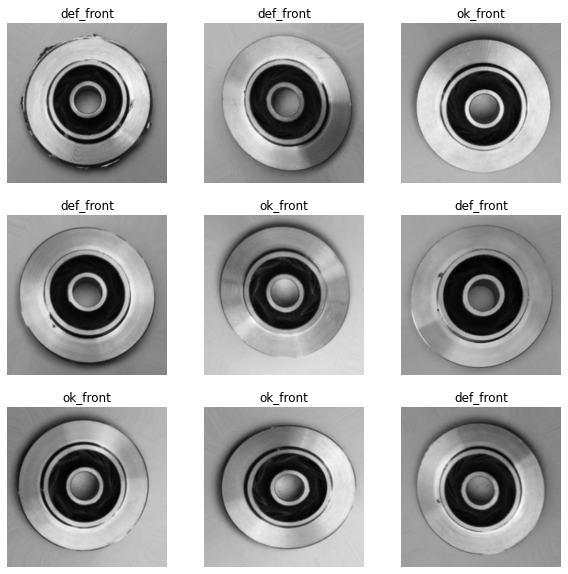

In [ ]:
# 데이터 샘플 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#이미지 전처리
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_scaled = train.map(lambda x, y: (normalization_layer(x), y))
val_scaled = val.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
#전처리 확인
image_batch, labels_batch = next(iter(train_scaled))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.00097105745 0.9865977


## 모델 구현

### 전이학습 모델 불러오기

In [ ]:
from tensorflow.keras.applications import Xception
xception = Xception(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
#xception 모델은 학습하지 않는다
for layer in xception.layers:
    layer.trainable = False

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

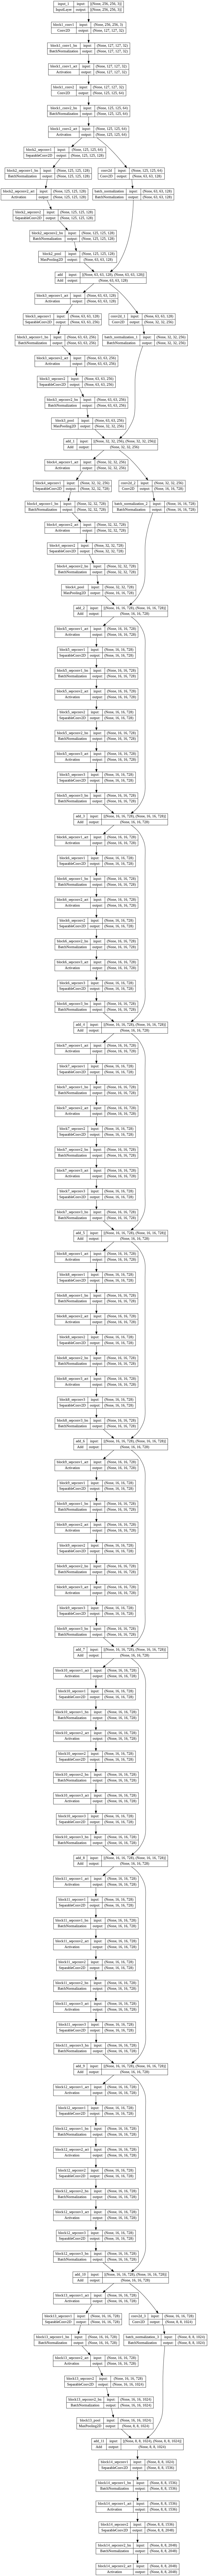

In [ ]:
#xception 모델 구조 확인
xception.summary()
tf.keras.utils.plot_model(xception, show_shapes=True)

### 하이퍼 파라미터 서칭을 위한 모델 빌드

In [ ]:
def model_builder(hp):
    #탐색할 하이퍼 파라미터 지정 
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    hp_drop_rate = hp.Float('rate', min_value=0.1, max_value=0.5,step=0.1 )
    
    model = tf.keras.Sequential([
    xception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=hp_units, activation="relu"),
    tf.keras.layers.Dropout(hp_drop_rate),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ])
    
    model.compile(optimizer = 'Adam',
                loss='binary_crossentropy',
                metrics = ['accuracy'])

    return model

### 하이퍼 파라미터 서칭

In [ ]:
!pip install -U keras-tuner
import kerastuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 13.7 MB/s 
     |████████████████████████████████| 1.6 MB 65.7 MB/s 


<ipython-input-12-5f8c033ce5cd>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')    

In [ ]:
# 출력을 지우는 콜백함수
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(train_scaled, epochs = 10, validation_data = val_scaled, callbacks = [ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 30 Complete [00h 12m 24s]
val_accuracy: 0.9944055676460266

Best val_accuracy So Far: 0.9944055676460266
Total elapsed time: 02h 27m 23s


In [ ]:
print(f""" 
최적의 하이퍼 파라미터
units : {best_hps.get('units')}
dropout rate : {best_hps.get('rate')}
""")

 
최적의 하이퍼 파라미터
units : 480
dropout rate : 0.2



### 모델 학습

In [ ]:
# 최적의 하이퍼 파라미터로 모델 빌딩
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 480)               62915040  
                                                                 
 dropout_1 (Dropout)         (None, 480)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 481       
                                                                 
Total params: 83,777,001
Trainable params: 62,915,521
Non-trainable params: 20,861,480
_________________________________________________________________


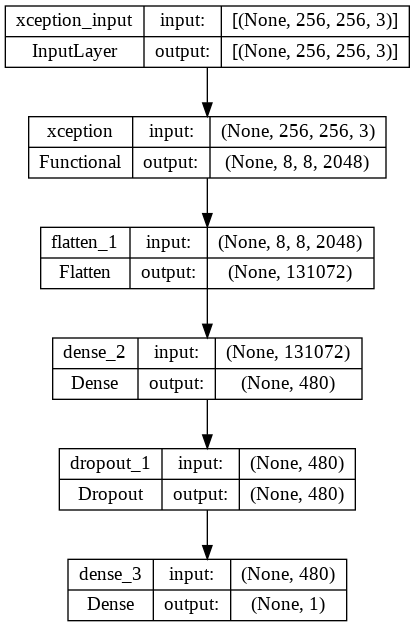

In [ ]:
#모델 시각화
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# 모델 학습
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_scaled, epochs = 50, validation_data = val_scaled, callbacks = [EarlyStopping])

Epoch 1/50
208/208 [==============================] - 52s 232ms/step - loss: 0.8801 - accuracy: 0.9388 - val_loss: 0.0471 - val_accuracy: 0.9902
Epoch 2/50
208/208 [==============================] - 47s 225ms/step - loss: 0.0843 - accuracy: 0.9796 - val_loss: 0.0707 - val_accuracy: 0.9804
Epoch 3/50
208/208 [==============================] - 48s 229ms/step - loss: 0.0429 - accuracy: 0.9869 - val_loss: 0.0454 - val_accuracy: 0.9832
Epoch 4/50
208/208 [==============================] - 47s 223ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0285 - val_accuracy: 0.9902
Epoch 5/50
208/208 [==============================] - 48s 226ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0355 - val_accuracy: 0.9916
Epoch 6/50
208/208 [==============================] - 48s 229ms/step - loss: 0.0203 - accuracy: 0.9940 - val_loss: 0.0273 - val_accuracy: 0.9916
Epoch 7/50
208/208 [==============================] - 48s 229ms/step - loss: 0.0349 - accuracy: 0.9890 - val_loss: 0.0323 - val_ac

In [ ]:
model.evaluate(val_scaled)

23/23 [==============================] - 5s 176ms/step - loss: 0.0342 - accuracy: 0.9888


[0.03423522412776947, 0.988811194896698]

### 학습곡선 시각화

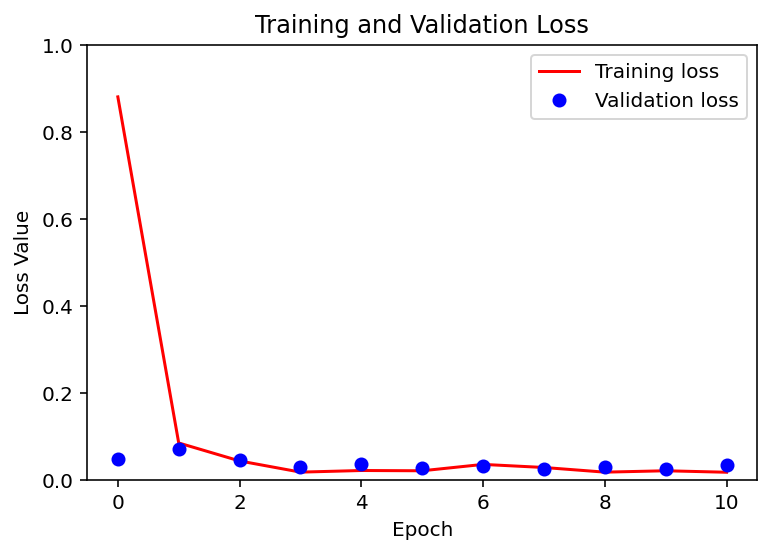

In [ ]:
#학습 히스토리 시각화
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#학습곡선 시각화
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(11)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### 이미지 하나를 입력하여 어떻게 예측하는지 확인해보기  
학습에 사용하지 않은 결함품 이미지를 3장 사용

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
# 이미지를 한장 불러와서 보여주고, 예측값을 출력하는 함수
def pred_defect(img_url):
    image = load_img(img_url)
    input_arr = img_to_array(image) / 255.
    input_arr = tf.image.resize(input_arr,(256,256))
    plt.imshow(input_arr)
    input_arr = np.array([input_arr])
    predictions = model.predict(input_arr)
    print(f'예측값 : {predictions}')
    pred_class = np.round(predictions)[0]
    print(f'예측 클래스 : {class_names[int(pred_class)]}')

1/1 [==============================] - 0s 26ms/step
예측값 : [[2.6456664e-08]]
예측 클래스 : def_front


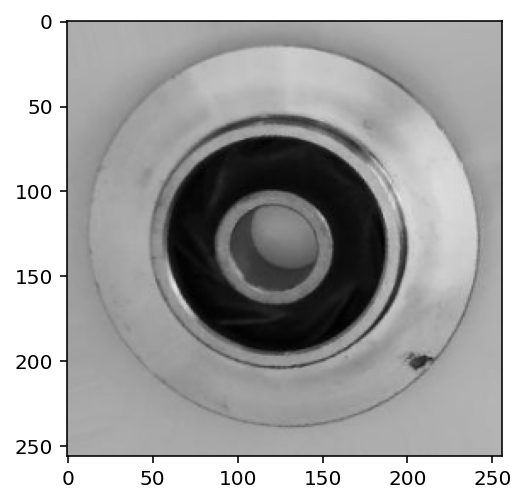

In [ ]:
pred_defect('/content/drive/MyDrive/casting_data/test_image1.jpeg')

1/1 [==============================] - 0s 25ms/step
예측값 : [[2.9174356e-12]]
예측 클래스 : def_front


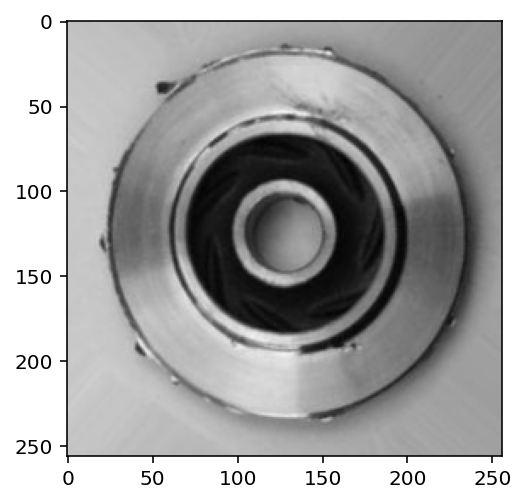

In [ ]:
pred_defect('/content/drive/MyDrive/casting_data/test_image2.jpeg')

1/1 [==============================] - 0s 28ms/step
예측값 : [[3.8129368e-08]]
예측 클래스 : def_front


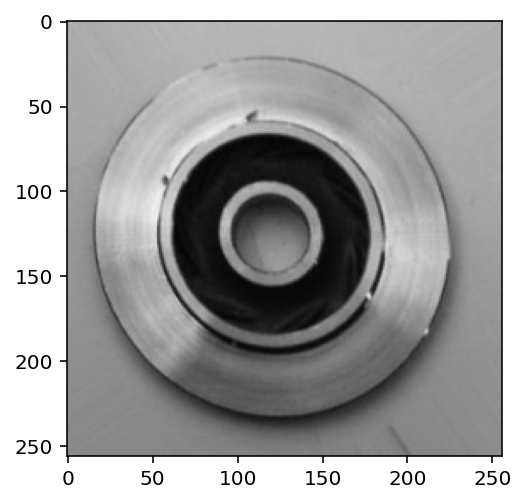

In [ ]:
pred_defect('/content/drive/MyDrive/casting_data/test_image3.jpeg')

제대로 예측하는것을 확인하였다.

학습에 사용하지 않은 정상품질 이미지를 3장 사용

1/1 [==============================] - 0s 24ms/step
예측값 : [[0.99466383]]
예측 클래스 : ok_front


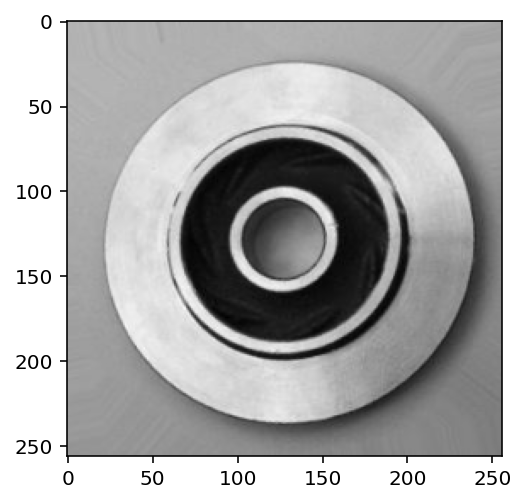

In [ ]:
pred_defect('/content/drive/MyDrive/casting_data/test_image4.jpeg')

1/1 [==============================] - 0s 22ms/step
예측값 : [[0.98745745]]
예측 클래스 : ok_front


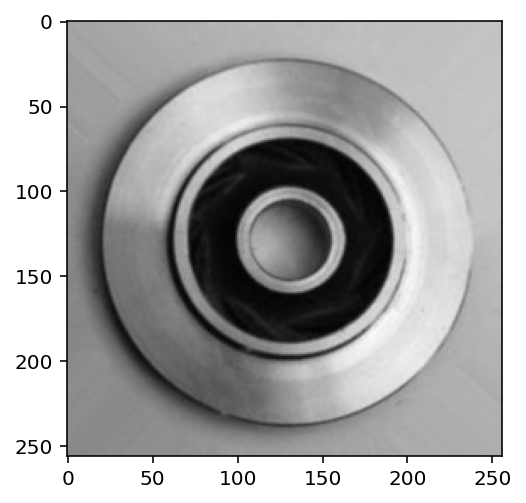

In [ ]:
pred_defect('/content/drive/MyDrive/casting_data/test_image5.jpeg')

1/1 [==============================] - 0s 25ms/step
예측값 : [[0.99455875]]
예측 클래스 : ok_front


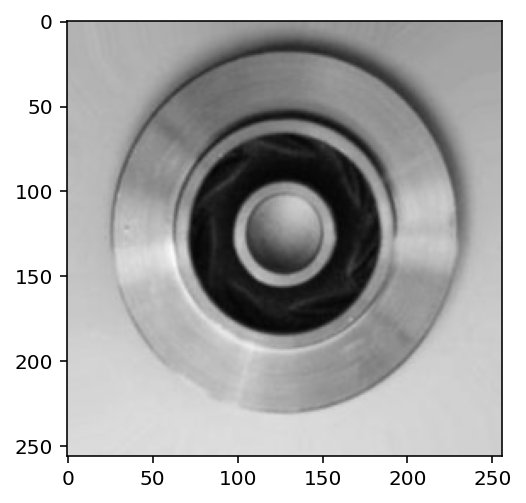

In [ ]:
pred_defect('/content/drive/MyDrive/casting_data/test_image6.jpeg')